# Song Clustering

Nicolas Thiel (i6254307)

MSB1015 Scientifc Programming

Maastricht Univseristy

## Library Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from kmodes.kprototypes import KPrototypes


## Load Data

In [ ]:
df = pd.read_csv('data/spotify-features_cleaned.csv')

continuous_features = ['popularity', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']
categorical_features = ['key', 'mode', 'time_signature']

print(df.shape)

(141608, 18)


In [ ]:
# scale data for later
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[continuous_features])

In [ ]:
# pca for later and visualizations
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)
pca_var = pca.explained_variance_ratio_

print(X_pca.shape)

(141608, 8)


## Plotting Functions

In [ ]:
def elbowplot(X, k_min=2, k_max=20, title="Elbow Plot"):
    # Elbow plot with inertia and silhouette score
    inertias = []
    silhouette_scores = []
    for k in range(k_min, k_max + 1):
        km = KMeans(n_clusters=k, random_state=1, n_init=10)
        km.fit(X)
        inertias.append(km.inertia_)
        silhouette_scores.append(silhouette_score(X, km.labels_, sample_size=1000))
    
    fig, ax1 = plt.subplots(figsize=(8,5))
    ks = list(range(k_min, k_max + 1))
    ax1.plot(ks, inertias, marker="o", color="blue")
    ax1.set_xlabel("Number of clusters (k)")
    ax1.set_ylabel("Inertia (Elbow)", color="blue")
    ax1.set_xticks(ks)
    ax2 = ax1.twinx()
    ax2.plot(ks, silhouette_scores, marker="s", color="red")
    ax2.set_ylabel("Silhouette Score", color="red")
    plt.title(title)
    plt.show()


def cluster_scatter_plot(X_pca, pca_var, labels, centers=None, type="pca", title="Cluster Scatter Plot"):
    # 2D scatter plot visualizing clusters in PCA space, optionally with cluster centers
    plt.figure()
    palette = sns.color_palette("tab10", n_colors=len(np.unique(labels)))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette=palette, alpha=0.5, s=10, legend=False)
    plt.xlabel(f"PC1 ({pca_var[0]*100:.1f}% variance)")
    plt.ylabel(f"PC2 ({pca_var[1]*100:.1f}% variance)")
    plt.title(title)

    if centers is not None:
        centroids_pca = pca.transform(centers)
        for i, coords in enumerate(centroids_pca):
            x, y = coords[0], coords[1]
            sns.scatterplot(x=[x], y=[y], color=palette[i], s=100, marker='X', edgecolor='black')
    plt.show()


def cluster_counts_plot(labels, title="Number of Songs per Cluster"):
    # Bar plot showing number of songs in each cluster
    cluster_counts = pd.Series(labels).value_counts().sort_index()
    plt.figure(figsize=(8,5))
    sns.barplot(
        x=cluster_counts.index,
        y=cluster_counts.values,
        hue=cluster_counts.index,
        palette="tab10",
        legend=False
    )
    plt.xlabel("Cluster")
    plt.ylabel("Number of Songs")
    plt.title(title)
    plt.show()


def feature_per_center_plot(centers, features, title="Feature values per cluster center"):
    # Bar plot showing feature values for each cluster center
    centers = pd.DataFrame(centers, columns=features)
    centers.T.plot(kind='bar', figsize=(10, 6), legend=False)
    plt.title(title)
    plt.ylabel("Scaled feature value")
    plt.show()


def cluster_violin_plot(X, labels, features, title="Feature Distributions per Cluster"):
    # Violin plots showing feature distributions per cluster
    fig, axes = plt.subplots(2, round(len(features)/2), figsize=(22, 10))
    axes = axes.flatten()

    for i, feature in enumerate(features):
        sns.violinplot(
            data=X,
            x=labels,
            y=feature,
            hue=labels,
            palette="tab10",
            dodge=False,
            ax=axes[i],
            legend=False
        )
        axes[i].set_title(feature)
        axes[i].set_xlabel('Cluster')
        axes[i].set_ylabel(feature)

    plt.tight_layout()
    plt.suptitle(title, y=1.02, fontsize=16)
    plt.show()

## K-means on Original Data

### Elbow Analysis

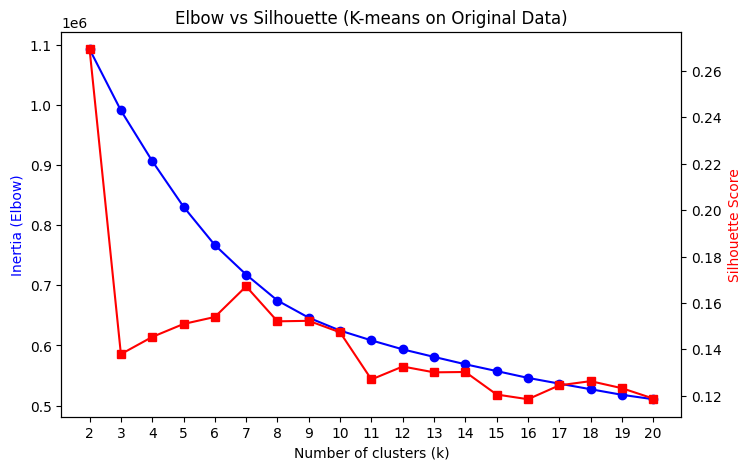

In [ ]:
elbowplot(X_scaled, k_min=2, k_max=20, title="Elbow vs Silhouette (K-means on Original Data)")

I decided on k=7, as no clear elbow can be observed and this point seems as the best trade-off between intertia and silhouette score.

### Clustering

In [ ]:
kmeans_original = KMeans(n_clusters=7, n_init=10, random_state=1)
kmeans_original.fit(X_scaled)

,n_clusters,7
,init,'k-means++'
,n_init,10
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,1
,copy_x,True
,algorithm,'lloyd'


### Plotting

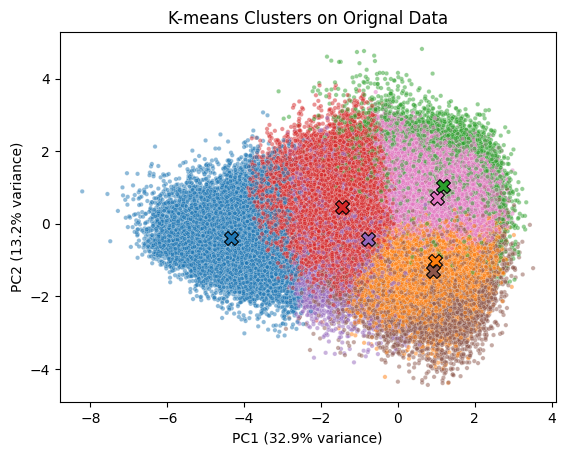

In [ ]:
cluster_scatter_plot(X_pca, pca_var, kmeans_original.labels_, kmeans_original.cluster_centers_, title="K-means Clusters on Orignal Data")

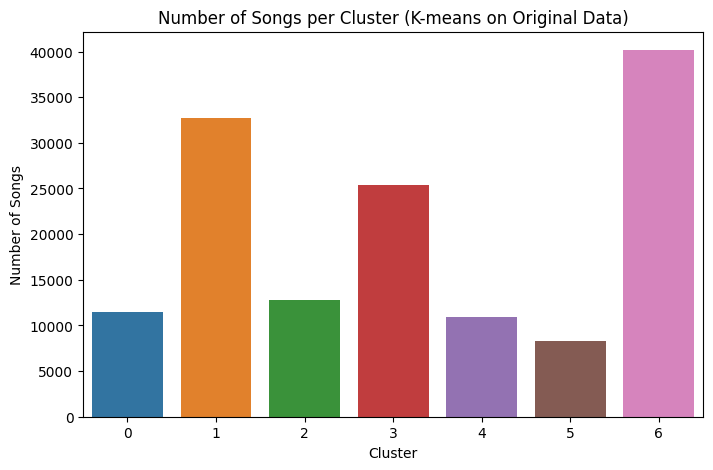

In [ ]:
cluster_counts_plot(kmeans_original.labels_, title="Number of Songs per Cluster (K-means on Original Data)")

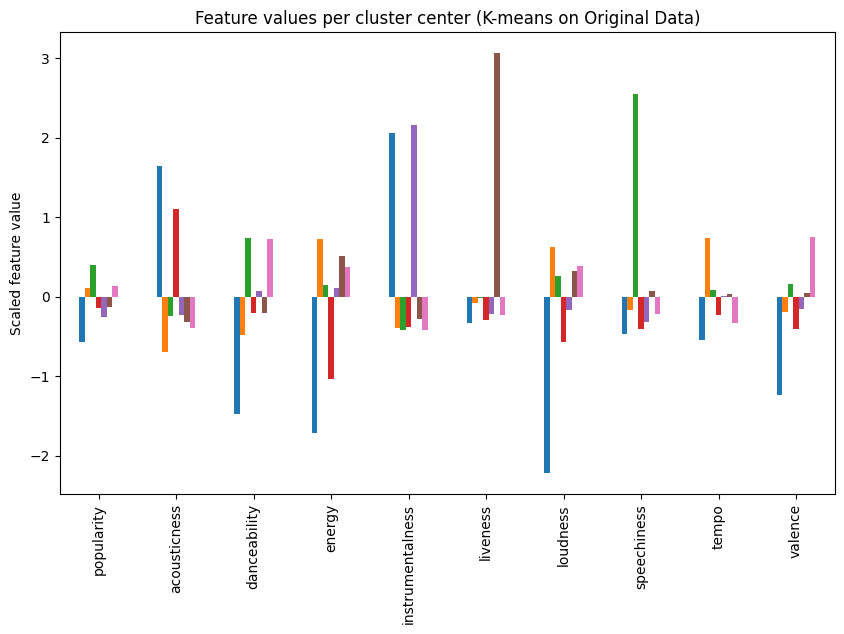

In [ ]:
feature_per_center_plot(kmeans_original.cluster_centers_, continuous_features, title="Feature values per cluster center (K-means on Original Data)")

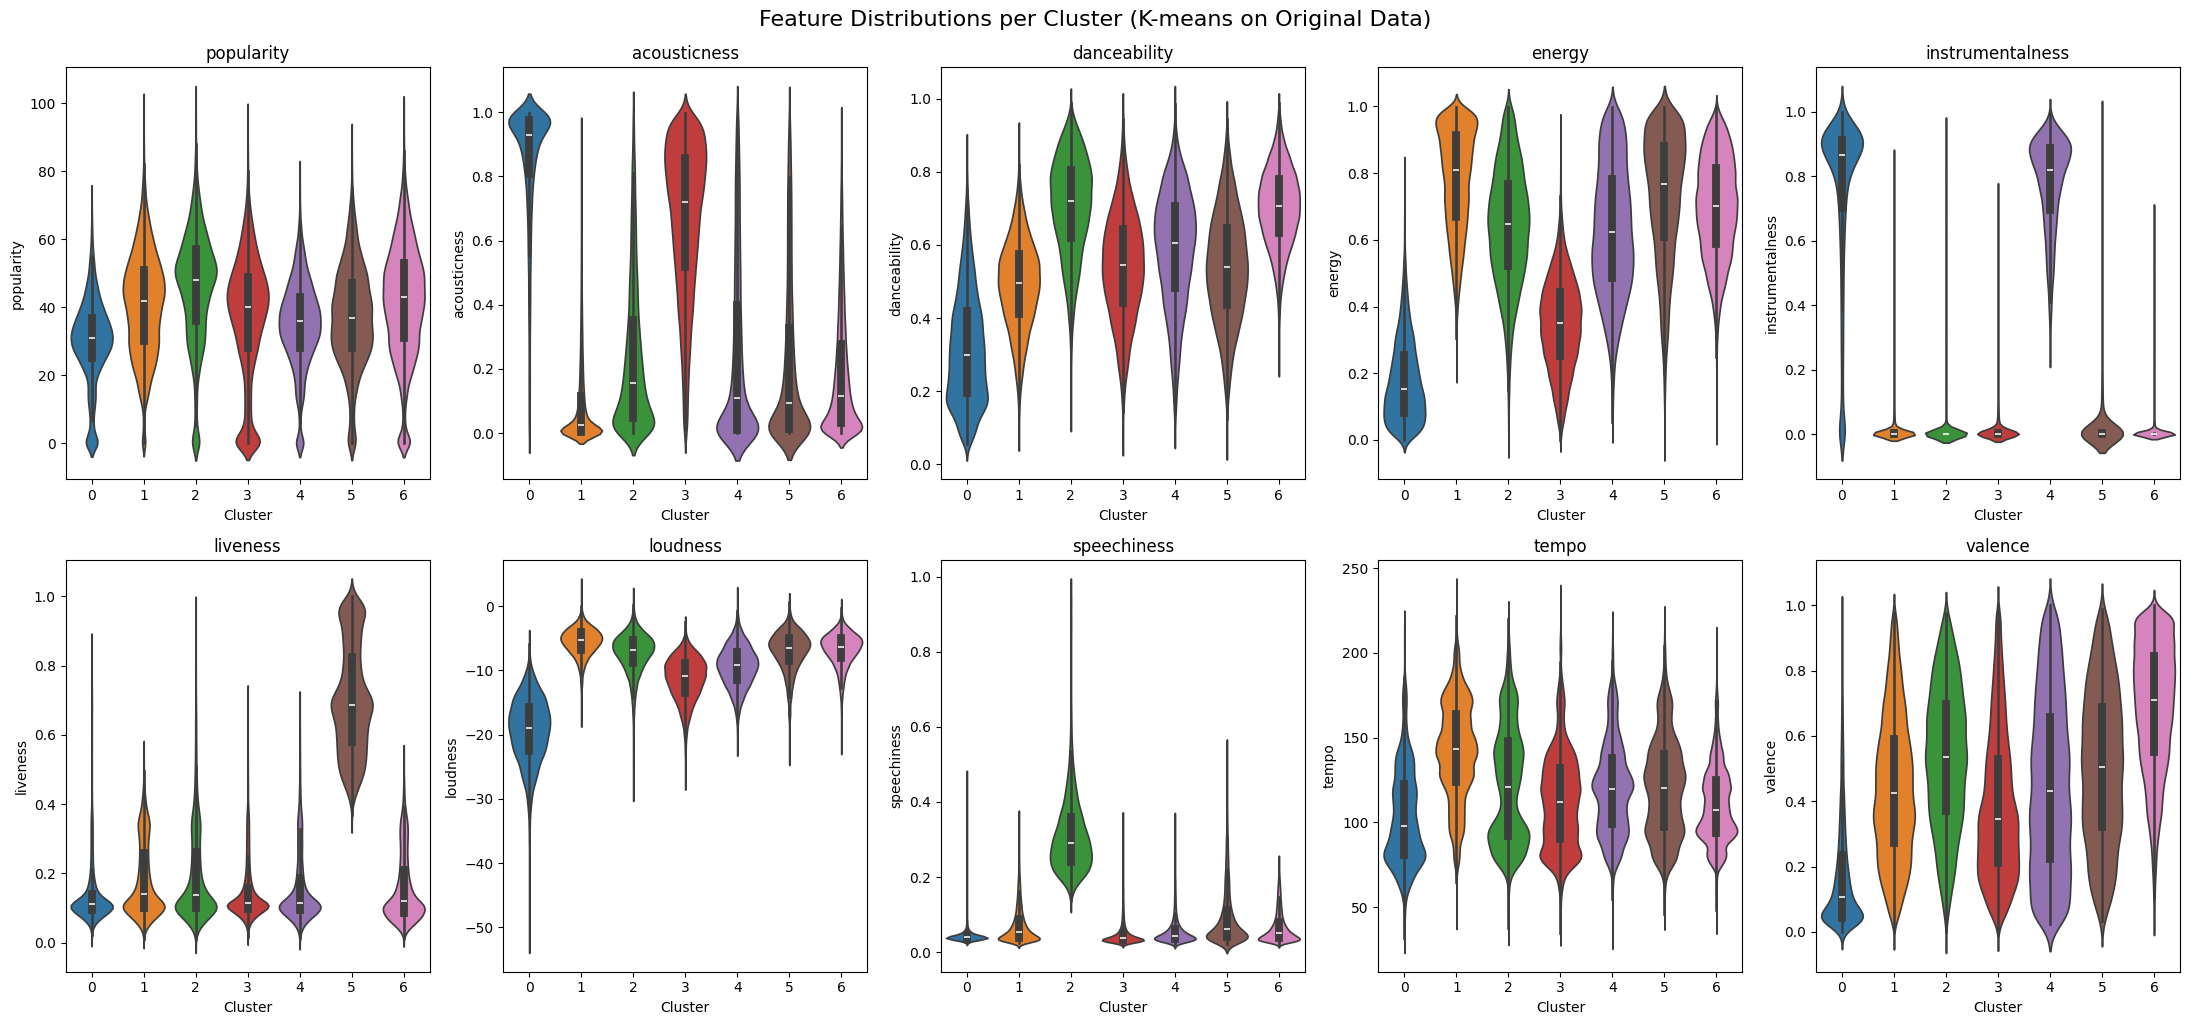

In [ ]:
cluster_violin_plot(df, kmeans_original.labels_, continuous_features, title="Feature Distributions per Cluster (K-means on Original Data)")

## K-means on Dimensionality-reduced Data

### Elbow Analysis

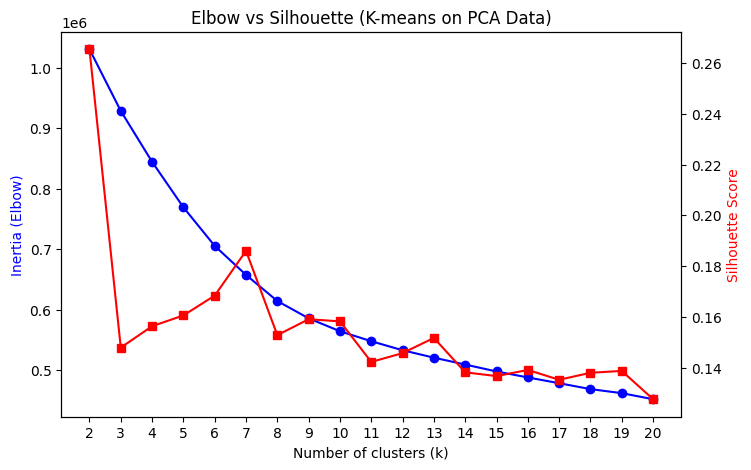

In [ ]:
elbowplot(X_pca, k_min=2, k_max=20, title="Elbow vs Silhouette (K-means on PCA Data)")

Here, we see a clearer elbowin the range of 7-9. I decided on k=7 as the silhouette score is ok and this makes comparisson easier to previous analysis.

### Clustering

In [ ]:
kmeans_reduced = KMeans(n_clusters=7, n_init=10, random_state=1)
kmeans_reduced.fit(X_pca)

,n_clusters,7
,init,'k-means++'
,n_init,10
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,1
,copy_x,True
,algorithm,'lloyd'


### Plotting

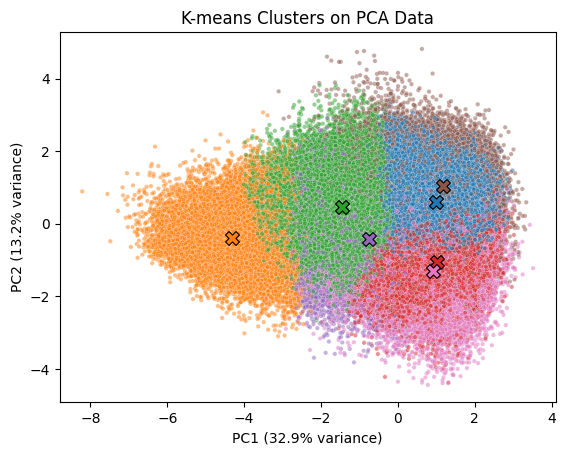

In [ ]:
cluster_scatter_plot(X_pca, pca_var, kmeans_reduced.labels_, pca.inverse_transform(kmeans_reduced.cluster_centers_), title="K-means Clusters on PCA Data")

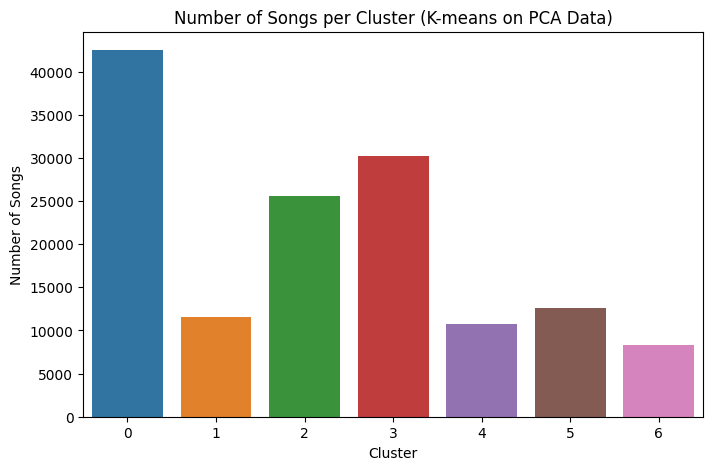

In [ ]:
cluster_counts_plot(kmeans_reduced.labels_, title="Number of Songs per Cluster (K-means on PCA Data)")

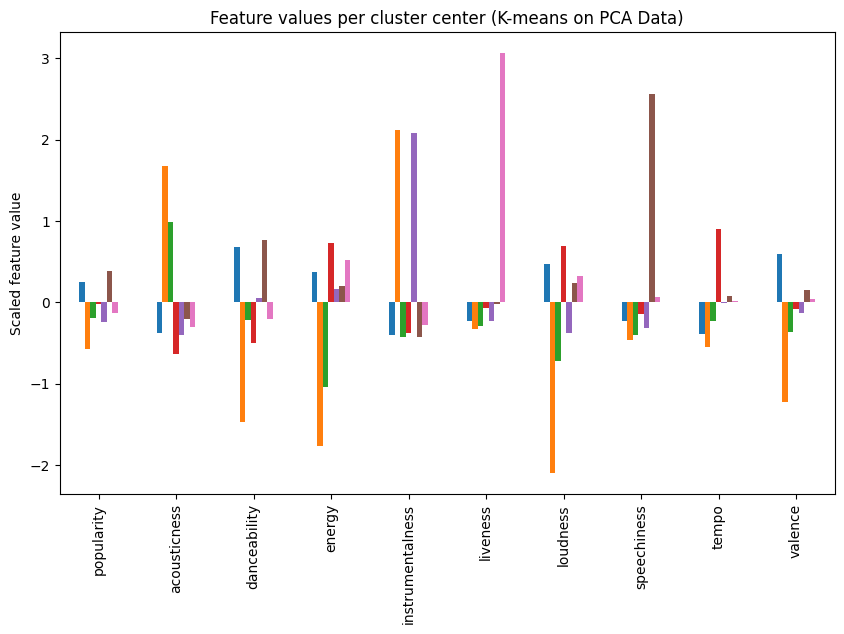

In [ ]:
feature_per_center_plot(pca.inverse_transform(kmeans_reduced.cluster_centers_), continuous_features, title="Feature values per cluster center (K-means on PCA Data)")

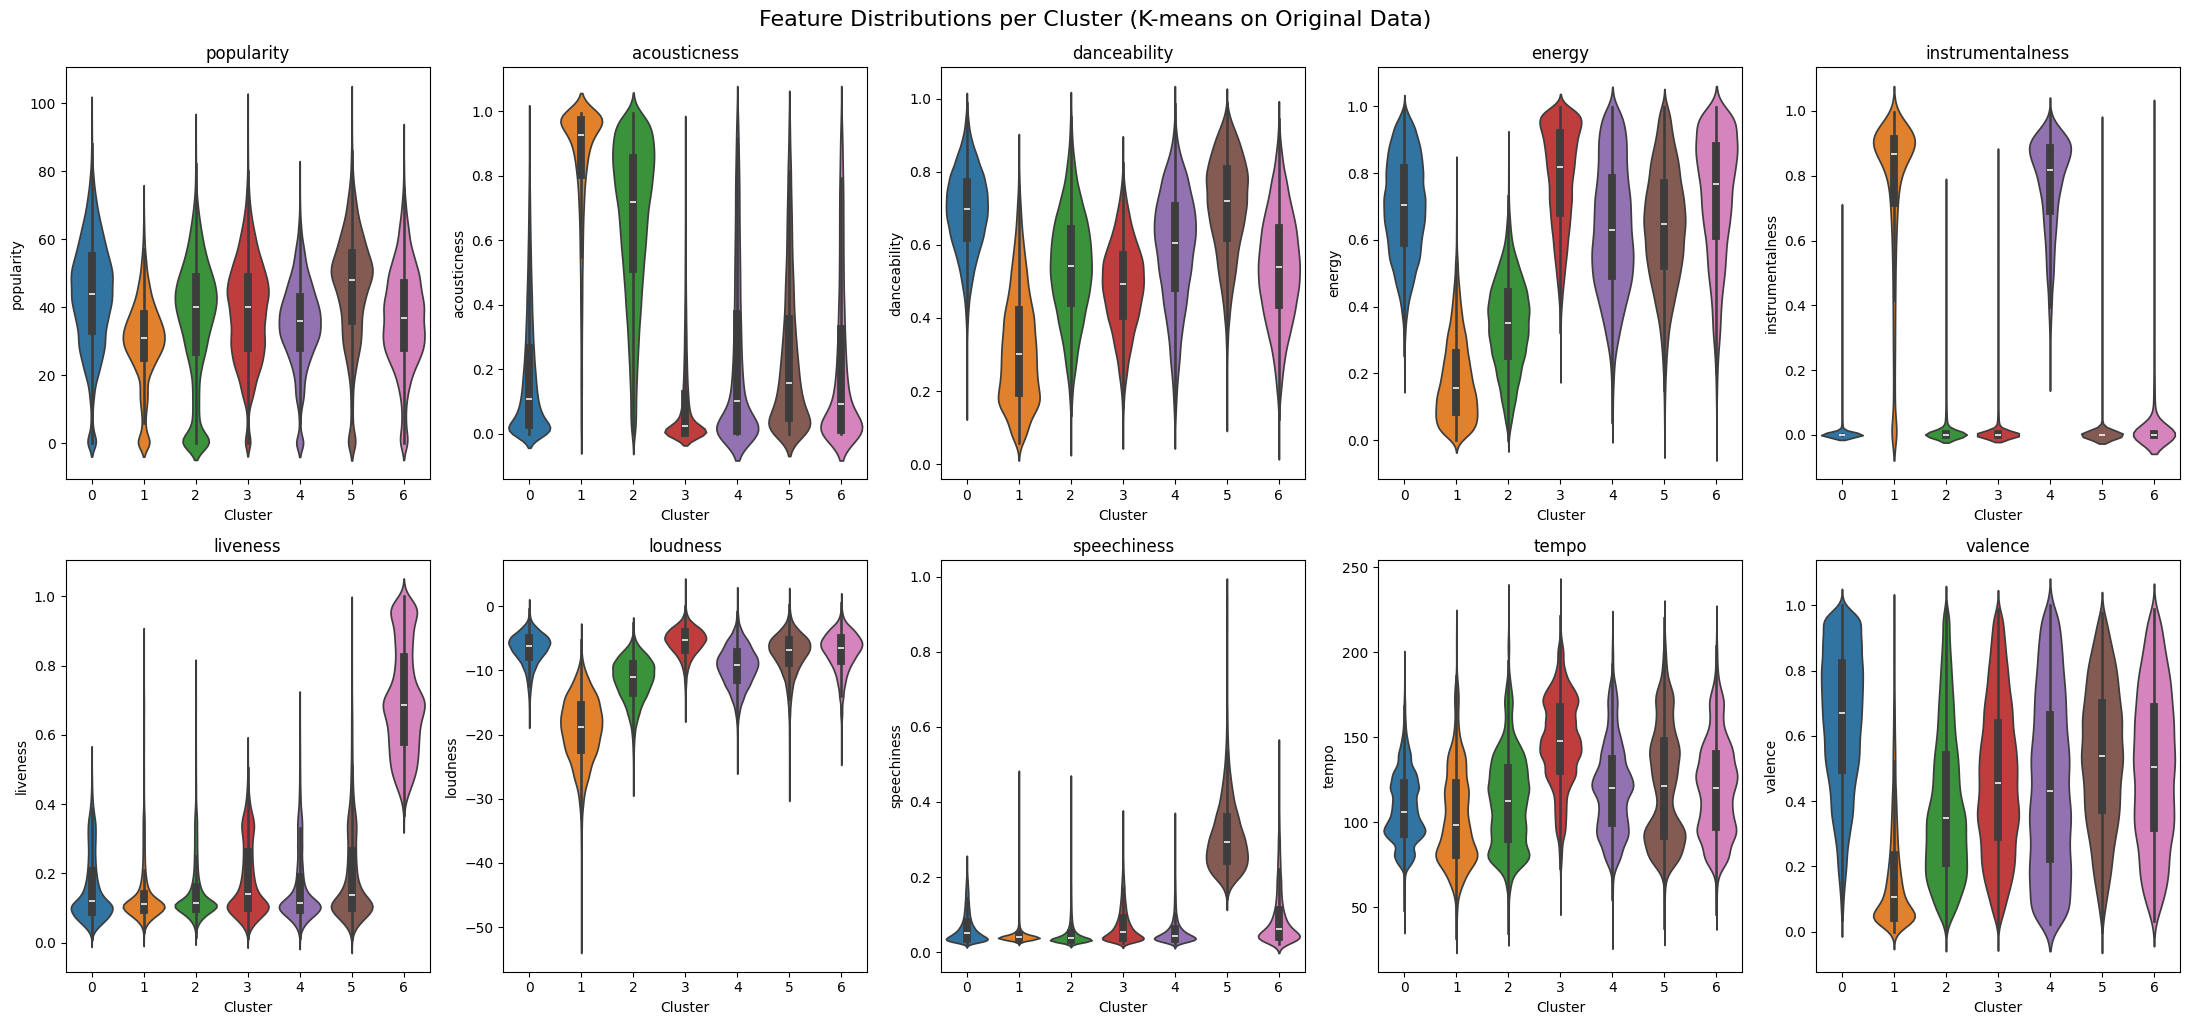

In [ ]:
cluster_violin_plot(df, kmeans_reduced.labels_, continuous_features, title="Feature Distributions per Cluster (K-means on Original Data)")

## Agglomerative Clustering on Unsupervised Random Forest Distance

### Pre-processing

In [ ]:
# standard scaling for continuous and one-hot encoding for categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), continuous_features),
        ('cat', OneHotEncoder(sparse_output=False), categorical_features)
    ]
)

In [ ]:
def sample_indices(n_total, n_samples, random_state=None, replace=True):
    rng = np.random.RandomState(random_state)
    return rng.choice(n_total, size=n_samples, replace=replace)

As URF is computationally expensive, I sample on 10k songs for this part of the analysis.

In [ ]:
# sample transformed data for URF
X = df[continuous_features + categorical_features]
X_transformed = preprocessor.fit_transform(X)
indices = sample_indices(X_transformed.shape[0], n_samples=10000, random_state=1, replace=False)

X_transformed_sampled = X_transformed[indices]
X_pca_sampled = X_pca[indices] # for visualization

In [ ]:
# create synthetic data
X_synthetic = pd.DataFrame(
        {i: np.random.permutation(X_transformed_sampled[:, i]) for i in range(X_transformed_sampled.shape[1])}
)

# combine real and synthetic data
X_combined = np.vstack([X_transformed_sampled, X_synthetic])
y_combined = np.hstack([np.ones(X_transformed_sampled.shape[0]), np.zeros(X_synthetic.shape[0])])

### Unsupervised Random Forest

In [ ]:
rf = RandomForestClassifier(n_estimators=500, random_state=1)
rf.fit(X_combined, y_combined)

,n_estimators,500
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
# sanity check
y_pred = rf.predict(X_combined)
print("Random Forest accuracy:", accuracy_score(y_combined, y_pred))

Random Forest accuracy: 1.0


In [ ]:
# get leaf indices for each tree
leaves = rf.apply(X_transformed_sampled)
n_trees = leaves.shape[1]
n_samples = X_transformed_sampled.shape[0]

# compute proximity
proximity = np.zeros((n_samples, n_samples))
for i in range(n_trees):
    leaf = leaves[:, i]
    for l in np.unique(leaf):
        idx = np.where(leaf == l)[0]
        for a in idx:
            proximity[a, idx] += 1

proximity /= n_trees
distance = 1 - proximity

### Clustering

In [ ]:
from sklearn.cluster import AgglomerativeClustering

# agglomerative clustering on distance matrix
urf_agglo = AgglomerativeClustering(n_clusters=3, metric='precomputed',linkage='average')
urf_agglo.fit(distance)

,n_clusters,3
,metric,'precomputed'
,memory,None
,connectivity,None
,compute_full_tree,'auto'
,linkage,'average'
,distance_threshold,None
,compute_distances,False


In [ ]:
silhouette_score(distance, urf_agglo.labels_, metric='precomputed')

0.007357637834283344

### Analysis

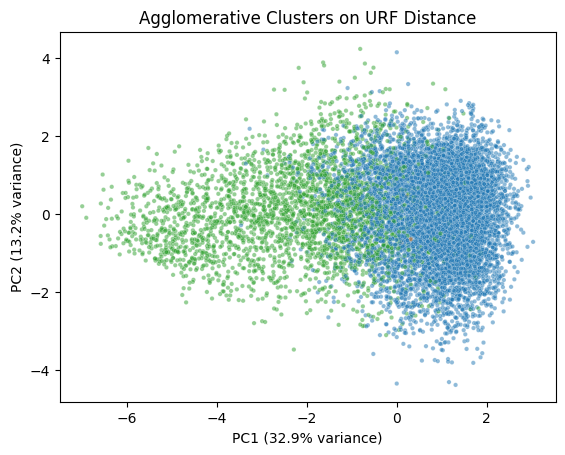

In [ ]:
cluster_scatter_plot(X_pca_sampled, pca_var, urf_agglo.labels_, title="Agglomerative Clusters on URF Distance")

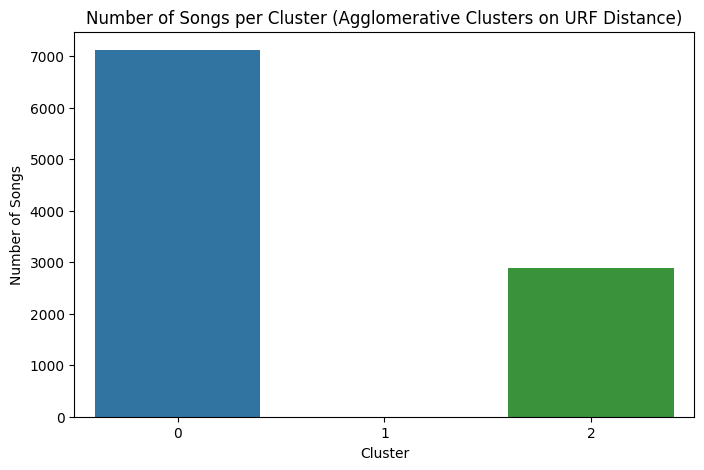

In [ ]:
cluster_counts_plot(urf_agglo.labels_, title="Number of Songs per Cluster (Agglomerative Clusters on URF Distance)")

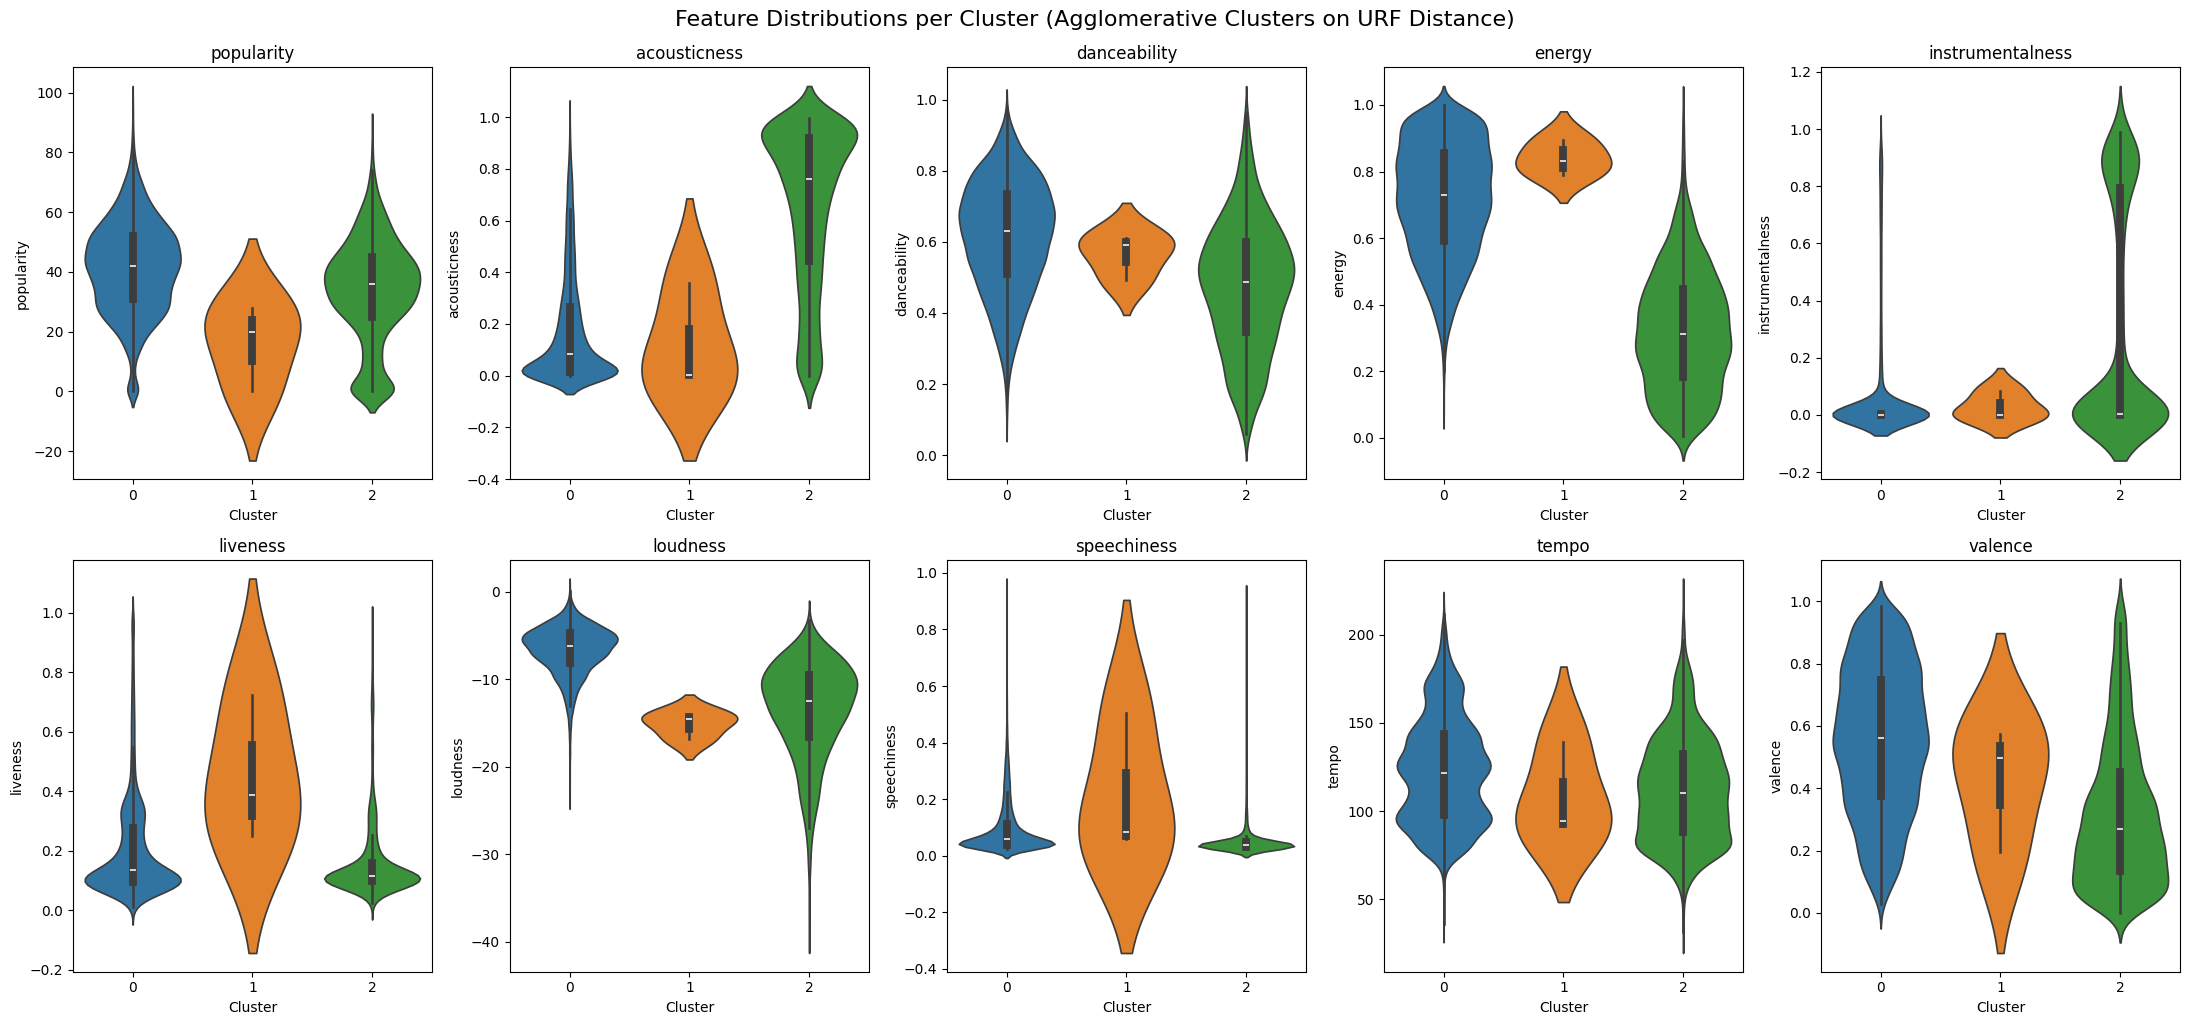

In [ ]:
cluster_violin_plot(df.iloc[indices], urf_agglo.labels_, continuous_features, title="Feature Distributions per Cluster (Agglomerative Clusters on URF Distance)")

## K-prototypes

In [ ]:
X_transformed = pd.concat([pd.DataFrame(X_scaled), df[categorical_features]], axis=1)
X_transformed.head()

,0,1,2,3,4,5,6,7,8,9,key,mode,time_signature
0,-2.393029,0.926309,-1.068100,1.236596,-0.481889,0.916864,1.399078,-0.365520,1.554784,1.246242,C#,Major,4/4
1,-2.332275,-0.199699,0.082949,0.536789,-0.481889,-0.259180,0.626125,0.017181,1.787939,1.253966,F#,Minor,4/4
2,-2.393029,1.210124,-1.921365,-1.125759,-0.481889,-0.575808,-0.745137,-0.510567,1.713524,-1.020814,C#,Major,4/4
3,-2.150011,1.972108,-1.400243,-1.534317,-0.063707,0.048400,-2.603872,-0.442507,0.679942,-0.391291,F,Major,4/4
4,-2.393029,1.352032,0.014230,-2.060993,-0.481889,-0.524544,-1.323557,0.644230,-1.080052,-0.514878,C#,Major,4/4


In [ ]:
X = X_transformed.to_numpy()
cat_idx = [X_transformed.columns.get_loc(col) for col in categorical_features]

Fitting k-prototypes takes a long time, so I provide the fitted model as well.

In [ ]:
train_kproto = False
if train_kproto:
    kproto = KPrototypes(n_clusters=7, init='Huang', random_state=1, n_jobs=4)
    kproto.fit(X_transformed, categorical=cat_idx)
    with open('models/kproto_fitted_7k.pkl', 'wb') as f:
        pickle.dump(kproto, f)
else:
    with open('models/kproto_fitted_7k.pkl', 'rb') as f:
        kproto = pickle.load(f)

In [ ]:
kproto_centroids = pd.DataFrame(kproto.cluster_centroids_, columns=continuous_features + categorical_features)
kproto_centroids.head()

,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,key,mode,time_signature
0,0.07733378948953665,-0.68779851744256,-0.4974378099491858,0.7267306405634381,-0.3940110107121991,-0.07978443698779458,0.6263804546603147,-0.161117941316279,0.7832895406143102,-0.17445198314784946,D,Major,4/4
1,-0.5712914268723785,1.651929798381673,-1.4798152871067027,-1.7218511316846672,2.061303810556253,-0.3261105338426038,-2.2242372639457795,-0.46511546651825264,-0.5504143990122629,-1.2315252264898469,C,Major,4/4
2,-0.1313387165625843,-0.312348216239096,-0.20805674822588147,0.5073713105010028,-0.273539264613596,3.064833635723193,0.31941143312886183,0.07018380496656325,0.027611723994840843,0.052391753386936114,C,Major,4/4
3,-0.25532744306648164,-0.2335848377623132,0.06600240406624205,0.10564312125932229,2.163252850335948,-0.22270037697253134,-0.16659534905614265,-0.3175706611882494,0.0017216953819662504,-0.16134840199590686,G,Major,4/4
4,0.3970542524417977,-0.2456497008606968,0.7448255587443839,0.15244304072159862,-0.4250832643593542,-0.021007327965760974,0.2624196851856796,2.5456052079546607,0.07998134697118474,0.15706080002694411,C#,Major,4/4


c:\Users\thiel\Documents\GitHub\spotify-song-clustering\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


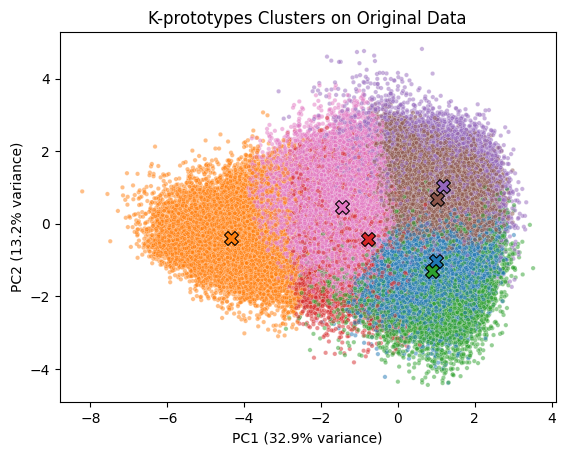

In [ ]:
cluster_scatter_plot(X_pca, pca_var, kproto.labels_, kproto_centroids[continuous_features], title="K-prototypes Clusters on Original Data")

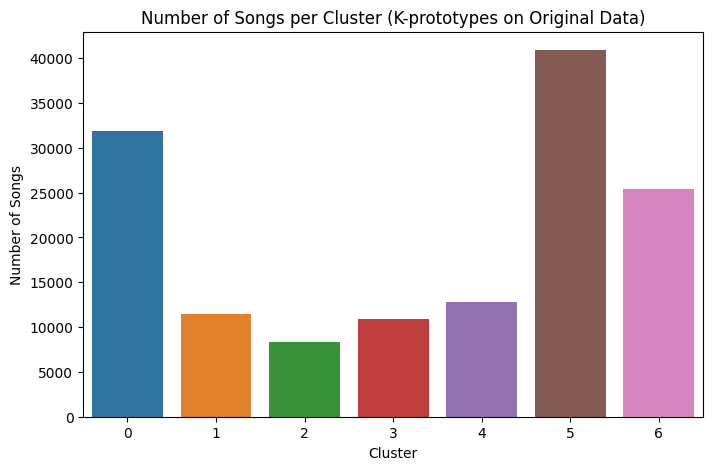

In [ ]:
cluster_counts_plot(kproto.labels_, title="Number of Songs per Cluster (K-prototypes on Original Data)")

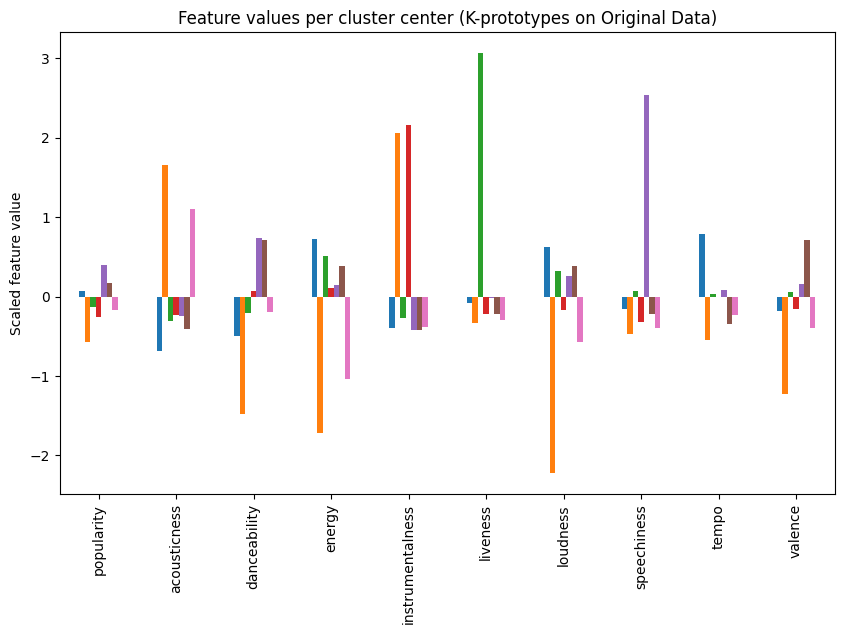

In [ ]:
feature_per_center_plot(kproto_centroids[continuous_features].astype(float).to_numpy(), continuous_features, title="Feature values per cluster center (K-prototypes on Original Data)")

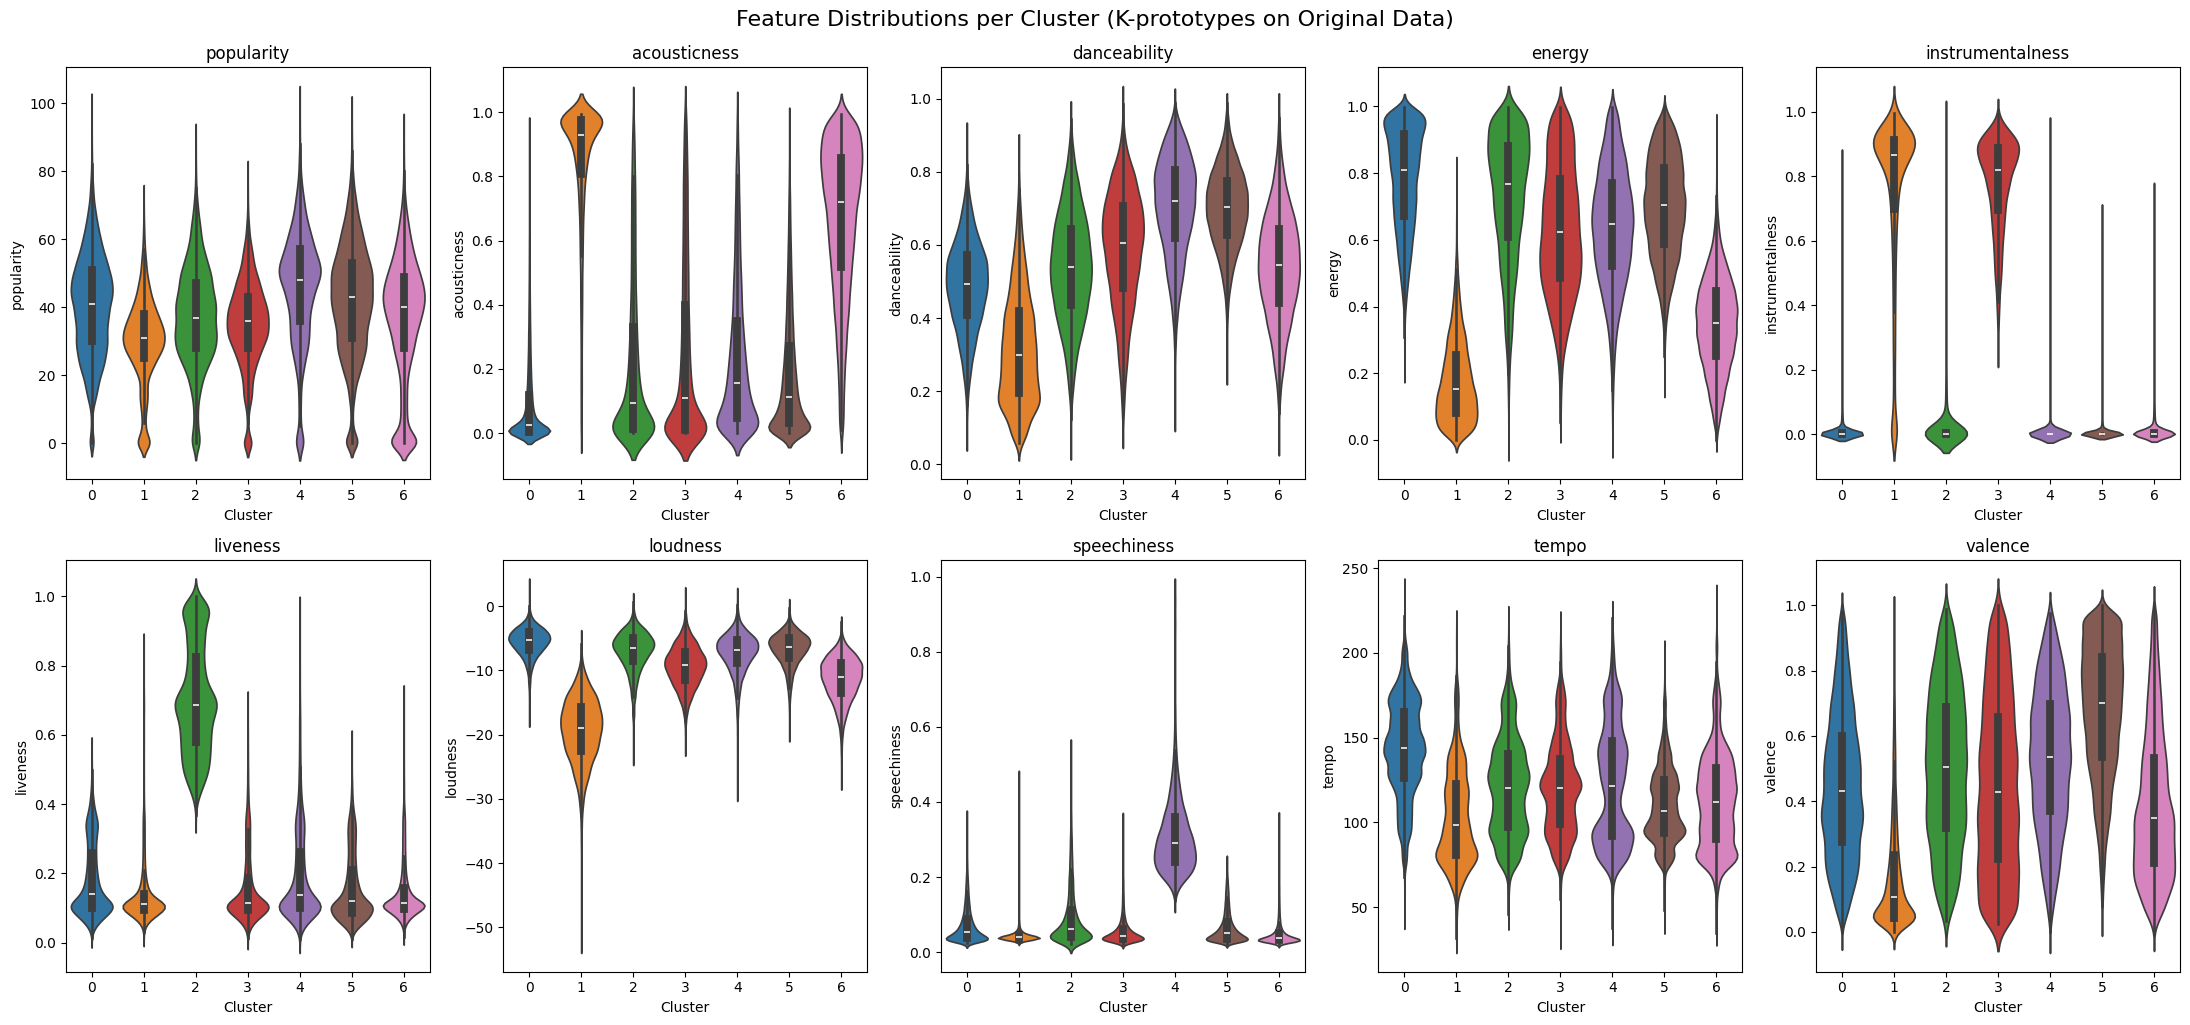

In [ ]:
cluster_violin_plot(df, kproto.labels_, continuous_features, title="Feature Distributions per Cluster (K-prototypes on Original Data)")